# Solve vibration ODE using scipy solve_ivp
Starting with importing the use python modules

In [1]:
import scipy as sc
import numpy as np
import sympy as sym
from sympy import init_printing
init_printing(use_latex='mathjax')
import matplotlib.pyplot as plt


In my [last post](https://dankremer.github.io/DanKremer/posts/numerical-ode-with-scipy/), i went through the derivation of a single body vibration problem, and how to evaluate it numerically. The main and most challenging part is the creation of the system equation that represents second order differential equation:

$$\frac{d}{dt}y(t)=\begin{cases}\frac{d}{dt}x(t)
\\-\frac{c}{m}\frac{d}{dt}x(t)-\frac{k}{m}x(t)
\end{cases}$$

In the last post I noted that the scipy documentation noted the alternative method called [solve_ivp](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html). In this post I will look at its use and some of the gotchas when using it. From the last post, my system equation was defined as follows:

In [2]:
def SDOF_system(y, t, m, k, c):
    x, dx = y
    dydt = [dx,
           -c/m*dx - k/m*x]
    
    return dydt

In order to evaluate this numerically, some system parameters were defined, along with initial conditions and the time based evaluation array:

In [3]:
m =0.25 # mass in kg
k= 1 # Spring Stiffnes N/m
c = 0.2# Dampening in Ns/m

y0 = [-2.0, 0.0] # initial conditions (Displacement, velocity)
t = np.linspace(0, 10, 1000) # times to evaluate

The documentation for the solve_ivp method staes that the function needs to have the following form

```python
y / dt = f(t,y)
y(t0) = y0
```
Initially I tried to just use my last function, and see what happen, but it didn't work right away. The first thing that caught me up was that the function failed, and could not initialize the time domain. After some frustrating time, I noticed that the input parameters to the function are location specific, IE you must past time first, and the the function y second, followed by function arguments. To fix this issue, the arguments of the SDOF_system need to be rewritten such that time comes first:


In [4]:
def SDOF_system(t, y, m, k, c):
    x, dx = y
    dydt = [dx, -c/m*dx - k/m*x]
    return dydt

The second thing that got me was that `solve_ivp` would not accept the `args` input. After some digging I found that I needed to update my scipy to something greater than 1.4 when the `args` input was implemented.

With these issues sorted, the solve_ivp method can be used:


In [5]:
from scipy.integrate import solve_ivp
sol = solve_ivp(SDOF_system, [0, 10], y0 = y0, args = (m,k,c), dense_output=True)

Note that in the above, I did not provide the entire time array, but merely the start and stop times [0, 10]. We can see what the solve_ivp outputs by  inspecting the variable sol:

In [6]:
sol

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 164
     njev: 0
      nlu: 0
      sol: <scipy.integrate._ivp.common.OdeSolution object at 0x7f026fec4048>
   status: 0
  success: True
        t: array([0.00000000e+00, 1.24937531e-04, 1.37431284e-03, 1.38680660e-02,
       1.38805597e-01, 5.58870210e-01, 1.05066458e+00, 1.49912850e+00,
       1.96920172e+00, 2.41409941e+00, 2.90006919e+00, 3.34442923e+00,
       3.78504896e+00, 4.27654821e+00, 4.72045558e+00, 5.19058952e+00,
       5.63956448e+00, 6.12364565e+00, 6.57203810e+00, 7.00876611e+00,
       7.44917087e+00, 7.88957564e+00, 8.36041316e+00, 8.80045984e+00,
       9.29058572e+00, 9.73220242e+00, 1.00000000e+01])
 t_events: None
        y: array([[-2.00000000e+00, -1.99999994e+00, -1.99999245e+00,
        -1.99923359e+00, -1.92617948e+00, -1.02241824e+00,
         3.79128770e-01,  1.02912297e+00,  8.06738442e-01,
         1.41146604e-01, -4.44473729e-01, -5.33371361e-01,
        -2.668

The output provides some interesting outputs:
- message: indicating the solver worked
- nfev, njev, nlu : these are various counts of steps, decompositions etc... (a bit beyond the scope here)
- sol: a common ODE solution
- t: a time array
- y: the results of x, and dx(t)
- t_events: a number of events that we could have specified (IE zero crossings etc).

We can plot the results, and see what the out come would be:

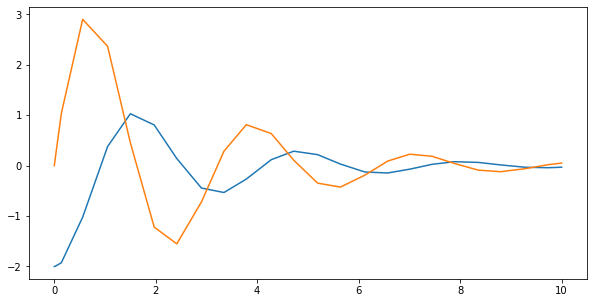

In [7]:
plt.figure(figsize=(10,5))
plt.plot(sol.t,sol.y.T)
plt.show()

The results are similar to what was determined previously, but with much less resolution. This is because of how we used the solver, and how it functions:

1) We specified a start time and end time, but no time array

2) The algorithm then figures our how many steps and the size needed to determine a correct evaluation.

This is very useful when you need to evaluate a computationally expensive system. You can first see if the evaluation will result in a solution using a very crude number of points, The solve_ivp docs also show how the output `sol` from solve_ivp, can then be used to generate a more refined results by submitting an array of time evaluation points:



In [8]:
z = sol.sol(t)

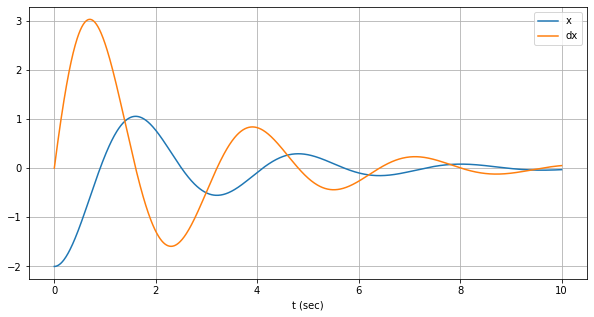

In [9]:
plt.figure(figsize=(10,5))
plt.plot(t,z.T)
plt.legend(['x', 'dx'], loc='best')
plt.xlabel('t (sec)')
plt.grid()

plt.show()

In the future I will look at the other inputs into this function and when they need to be use. As noted here it is important to have your system function written in the same sequence as required by the solver. 